# Sorting k in descending order into g-groups, using two reference (pressure, temperature) 


In [6]:
%matplotlib inline
from IPython import display
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib 
import matplotlib.pyplot as plt


In [7]:
matplotlib.rc('font', size=13)

# Toy distribution of k


In [8]:
# These functions are for simulating some k(v, p, t)

def kdist_shape(vmin=980, vmax=1100, dv=.002, 
                powrange=8,):
    vrange = vmax - vmin
    vs = vmin + dv * np.arange(int(vrange / dv) + 1)
    ks = np.sin(2 * np.pi * vs / vrange) + 1.5
    ks = ks ** powrange
    ks = 1e-22 * ks
    ks = ks * np.exp(- 5 * (vs - vmin) / vrange)
    return pd.Series(ks, index=vs)


def dict_pt_powerrange():
    return {(1, 250): 15, 
            (50, 250): 8}


def simulate_kdist(vmin=980, vmax=1100, dv=.002):
    d = dict_pt_powerrange()
     
    d_srs = {pt: kdist_shape(vmin=vmin, vmax=vmax, dv=dv,
                             powrange=powrange)
             for pt, powrange in d.items()}

    df = pd.DataFrame.from_dict(d_srs)
    df.columns.set_names(['P', 'T'], inplace=True)
    df.index.set_names('wavenumber', inplace=True)
    return df

    




In [9]:
# kdist_shape() example

#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

#powerranges = [8, 15, 20]

#for p in powerranges:
#    kdist_shape(powrange=p).plot(ax=ax, logy=True)
    
#ax.legend(powerranges)
#ax.grid(b=True)

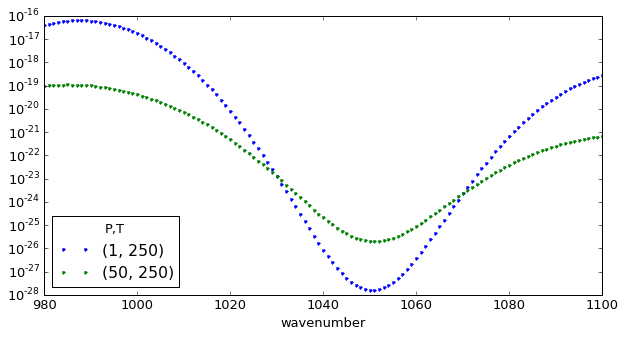

In [10]:
# simulate_kdist() example
df = simulate_kdist(dv=1)
df.plot(logy=True, figsize=(10, 5),
        linestyle='None', marker='.')

**Figure 1. Toy k(v, pt).**  
Let's say that the absorption coefficient as a function of wavenumber $\nu$ are as shown in the plot.  These have the property that, assuming in the Lorentzian regime, the higher pressure, the smaller the range of k, and the lower the pressure, the larger the range of k. 

In [11]:
# sort series from small to large and then plot
#df_sorted = df.sort_values(by=(1, 250))
#df_sorted = df_sorted.reset_index()
#df_sorted.index.set_names('wavenumer index', inplace=True)

#df_sorted[[(1, 250), (50, 250)]].plot(logy=True, linestyle='None',
#                                      marker='.', figsize=(10, 5))

# Sorting k

In [12]:
def value_bins(absth):
    return np.concatenate(([0], absth[1:-1], [1]), axis=0)


In [37]:
def plt_sorted_series(srs, absth=None):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

    axs[0].plot(srs.index, srs.values, 
                linestyle='None', marker='.', markersize=2)
    axs[0].set_ylabel('k')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('wavenumber [$cm^{-1}$]')
    
    axs[1].plot(srs.sort_values().values,
                linestyle='None', marker='.', markersize=2)
    axs[1].set_yscale('log')
    plt.setp(axs[1].get_yticklabels(), visible=False)
    axs[1].yaxis.set_tick_params(size=0)
    axs[1].set_xlabel('wavenumber index after sorting k')

    if absth != None:
        axgs = [ax.twinx() for ax in axs]
        axgs[0].get_shared_y_axes().join(*(list(axs) + list(axgs)))
        for v in absth:
            axgs[0].plot(srs.index, v * np.ones(srs.shape), 
                         color='grey', linestyle='--', linewidth=.5)
            axgs[1].plot(v * np.ones(srs.shape), 
                         color='grey', linestyle='--', linewidth=.5)
            
        axgs[0].set_yscale('log')
        axgs[0].yaxis.set_tick_params(size=0)
        plt.setp(axgs[0].get_yticklabels(), visible=False)
            
        axgs[1].set_ylabel('iabsth')
        axgs[1].set_yscale('log')
        axgs[1].set_yticks(absth)
        axgs[1].set_yticklabels(range(1, absth.shape[0] + 1))
        
#    plt.subplots_adjust(wspace=0)
    return fig, axs, axgs if absth != None else None



In [38]:
# total number of g-groups we are going for, ng
ng = 20

# high reference (P, T)
pt_high = (1, 250)

# low reference (P, T)
pt_low = (50, 250)

# the lowest g that is from sorting k at pt_high
g_high_inclusive = 7

Let `ng` be the total number of g-groups we look to end up with.  The two reference (pressure, temperature) pairs used are:

- high reference ---- `pt_high`
- low reference ---- `pt_low`

G-groups `g_high_inclusive` to `ng` will be obtained by sorting k using the high reference, while g-groups 1 to (`g_high_inclusive - 1`) will use the low reference.

In this example, the value used are:

In [62]:
print('ng =     ', ng)
print('pt_high =     ', pt_high)
print('pt_low =     ', pt_low)
print('g_high_inclusive =    ', g_high_inclusive)

ng =      20
pt_high =      (1, 250)
pt_low =      (50, 250)
g_high_inclusive =     7


In [84]:
# Evenly divide in log-space the range of k(pt = pt_high) 
# into `ng` intervals to get `absth_high`

absth_high = np.logspace(np.log10(df[pt_high].min()), 
                         np.log10(df[pt_high].max()), ng + 1)

First, evenly divide in log-space the range of k at `pt_high` into `ng` intervals to get a set of thresholds, `absth_high`.  Note that in the actual sorting, the smallest and largest thresholds here will not be used; anything smaller than the second smallest threshold will be binned to g-group 1, and anything larger than the second largest threshold will be binned to g-group `ng`.

In this example, the values of these thresholds, in ascending order, are:

In [85]:
print('absth_high =   ', absth_high)

absth_high =    [  1.65041576e-28   6.26941777e-28   2.38155743e-27   9.04679830e-27
   3.43659819e-26   1.30545710e-25   4.95902679e-25   1.88378053e-24
   7.15589817e-24   2.71830385e-23   1.03259935e-22   3.92252480e-22
   1.49004556e-21   5.66022109e-21   2.15014250e-20   8.16772473e-20
   3.10266539e-19   1.17860639e-18   4.47716025e-18   1.70073437e-17
   6.46056256e-17]


In [86]:
# Bin k(pt = pt_high) using absth_high
bins = value_bins(absth_high)

ncut_high = pd.cut(df[pt_high], bins=bins, 
                   labels=range(1, ng + 1), retbins=True)

We now bin the k at `pt_high` into `ng` g-groups using thresholds obtained from the high reference, `absth_high`.  Firstly, the appropriate bin edges are obtained from `absth_high`: for the bin for the largest k's, the lower edge is `absth_high[ng]`, and the higher edge is `1`; for the bin holding the smallest k's, the lower edge is 0 and the higher edge is `absth_high[1]`. 

In this example, the values of the bin edges are:

In [87]:
bins

array([  0.00000000e+00,   6.26941777e-28,   2.38155743e-27,
         9.04679830e-27,   3.43659819e-26,   1.30545710e-25,
         4.95902679e-25,   1.88378053e-24,   7.15589817e-24,
         2.71830385e-23,   1.03259935e-22,   3.92252480e-22,
         1.49004556e-21,   5.66022109e-21,   2.15014250e-20,
         8.16772473e-20,   3.10266539e-19,   1.17860639e-18,
         4.47716025e-18,   1.70073437e-17,   1.00000000e+00])

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


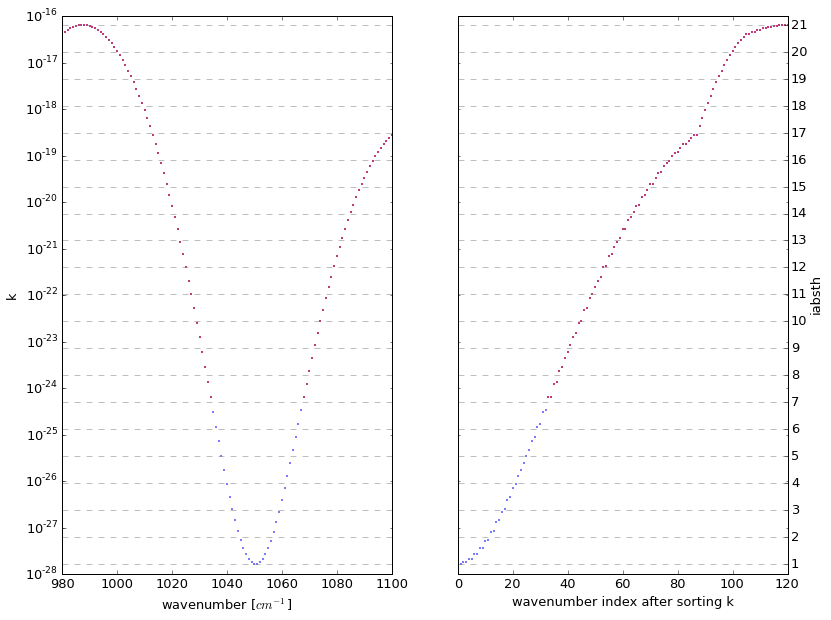

In [69]:
srs = df[pt_high]
absth = absth_high

fig, axs, axgs = plt_sorted_series(srs, absth=absth)


# over-plot to indicate wavenumbers in `wvns_high`
wvns_high = ncut_high[0][(ncut_high[0] >= g_high_inclusive)]

srs_sub = srs[wvns_high.index]
axs[0].plot(srs_sub.index, srs_sub.values, 
            color='r', linestyle='None', marker='.', markersize=2)

df_sorted = pd.DataFrame(srs.sort_values())
df_sorted['k-sort index'] = range(srs.shape[0])
df_sorted_sub = df_sorted.loc[wvns_high.index, :]

axs[1].plot(df_sorted_sub['k-sort index'], df_sorted_sub[srs.name].values,
            color='r', linestyle='None', marker='.', markersize=2)

**Figure 1. Absoroption coefficient at high reference.**   
(*left panel*) `k(pt = pt_high)`. (*right panel*) `k(pt = pt_high)` sorted by k.  On the left y-axis are shown the value of the absorption coefficient, k.  The horizontal dashed lines mark the g-groups' edges with the g-group number indicated on the right y-axis.  Everything above `iabsth = 20`, for example, belong to g-group 20, and everything below `iabsth = 2` belong to g-group 1.  The yellow section indicates the wavenumbers where the binning using the high reference will be kept for the final g-groups.  The blue section will be further binned using the low reference.

In [88]:
# Get the binned results where g < g_high_inclusive

# This gets us the wavenumbers that are not binned 
# in g-group `g_high_inclusive` or higher
wvns_low = ncut_high[0][(ncut_high[0] < g_high_inclusive)]

# Calculate the precentile of all wavenumbers that these represent
frac_low = wvns_low.shape[0] / ncut_high[0].shape[0]

Next, gather all the wavenumbers that have been binned in g-groups 1 to (`g_high_inclusive - 1`).  We will take these wavenumbers out and use the low reference, `pt_low`, to re-bin them.  

First, calculate what fraction (`frac_low`), of all the wavenumbers we started with, these represent.

In this example, 

In [70]:
print('frac_low =     ', frac_low)

frac_low =      0.2727272727272727


In [71]:
# There remains ng_low g-group to sort out
ng_low = g_high_inclusive - 1

There remains `ng_low` number of g-groups to finalise, to be determined using the low reference.

In this example,

In [72]:
print('ng_low =      ', ng_low)

ng_low =       6


In [73]:
# Evenly divide in log-space the range of the lowest 
# `frac_low` percentile of k(pt = pt_low) 
# into `ng_low` - 1 intervals to get `absth_low`


# Bin k(pt = pt_low) into 0 ~ frac_low percentile ('lower')
# and frac_low ~ 1 precentile ('higher')
qncut = pd.qcut(df[pt_low], [0, frac_low, 1], 
                labels=['lower', 'higher'],
                retbins=True)

# Find the range of the lower percentile of k(pt = pt_low)
vmin = df[pt_low][qncut[0] == 'lower'].min()
vmax = df[pt_low][qncut[0] == 'lower'].max()

# and create `absth_low`
absth_low = np.logspace(np.log10(vmin), np.log10(vmax), 
                        ng_low + 1)

Now, evenly divide, in log-space, the range of the lowest `frac_low` percentile of `k(pt = pt_low, v = all)` into `ng_low` intervals to get a set of thresholds, `absth_low`.

In this example, the obtained thresholds are:

In [89]:
print('absth_low =       ', absth_low)

absth_low =        [  2.07244080e-26   4.09068194e-26   8.07438202e-26   1.59375982e-25
   3.14583872e-25   6.20940566e-25   1.22564194e-24]


In [90]:
# Bin k(v = wvns_low, pt = pt_low) using absth_low

bins = value_bins(absth_low)

ncut_low = pd.cut(df[pt_low][wvns_low.index],
                  bins=bins, 
                  labels=range(1, ng_low + 1),
                  retbins=True)

Similar to using the high reference (see above), an appropriate set of bin edges are obtained from these.  

Then, `k(v = wvns_low, pt = pt_low)` are sorted into these bins.  That is, k at the low reference `pt_low` at wavenumbers `wvns_low` are sorted into these bins.

In this example, the bin edges are:

In [91]:
print(bins)

[  0.00000000e+00   4.09068194e-26   8.07438202e-26   1.59375982e-25
   3.14583872e-25   6.20940566e-25   1.00000000e+00]


/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


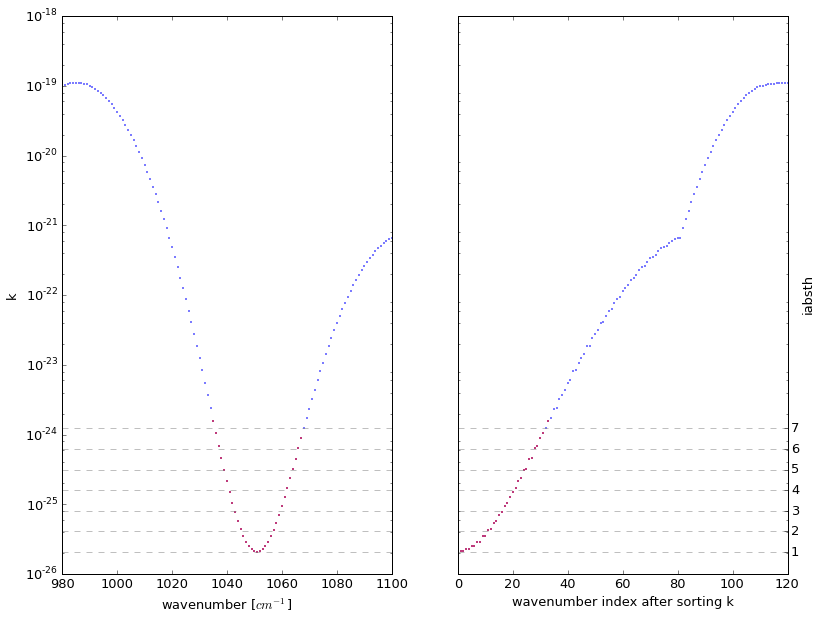

In [92]:
srs = df[pt_low]
absth = absth_low


fig, axs, axgs = plt_sorted_series(srs, absth=absth)

# over-plot to indicate wavenumbers in `wvns_low`
srs_sub = srs[wvns_low.index]
axs[0].plot(srs_sub.index, srs_sub.values, 
            color='r', linestyle='None', marker='.', markersize=2)

df_sorted = pd.DataFrame(srs.sort_values())
df_sorted['k-sort index'] = range(srs.shape[0])
df_sorted_sub = df_sorted.loc[wvns_low.index, :]

axs[1].plot(df_sorted_sub['k-sort index'], df_sorted_sub[srs.name].values,
            color='r', linestyle='None', marker='.', markersize=2)

**Figure 2. Absorption coefficient at low reference**  
(left panel) k(pt = pt_low). (right panel) k(pt = pt_low) sorted by k. On the left y-axis are shown the value of the absorption coefficient, k. The horizontal dashed lines mark the g-groups' edges with the g-group number indicated on the right y-axis. Everything above iabsth = 6, for example, belong to g-group 6, and everything below iabsth = 2 belong to g-group 1. The yellow section indicates the wavenumbers where the binning using the low reference will be kept for the final g-groups. The blue section have already been binned using the high reference previously.

In [93]:
# Gather the 14 g-groups first obtained with these 6 g-groups
# to get an overall 20-groups

mem_low = ncut_low[0]
mem_high = ncut_high[0][ncut_high[0] >= g_high_inclusive]

mem_low = mem_low.astype(np.int64)
mem_high = mem_high.astype(np.int64)


srs_mem = pd.concat([mem_low, mem_high], axis=0,)
srs_mem.sort_index(inplace=True)

After binning using the high and then the low references, the results are combined into the final result, which should tell us which wavenumbers belong to g-group 1, which belong to g-group 2, and so on.  g-groups 1 to `ng_low` are determined using the low reference, while g-groups `g_high_inclusive` to `ng` are determined using the high reference. 

In this example, here is a glimpse of the final results, seen as a mapping from wavenumber to g-group number.  The wavenumbers shown all belong to g-group 19.

In [94]:
print(srs_mem.head())

wavenumber
980    20
981    20
982    20
983    20
984    20
dtype: int64


In [95]:
# this shows that the union of the two sets of wavenumbers make up
# the original set

set(mem_low.index).union(set(mem_high.index))
set(mem_low.index).intersection(set(mem_high.index))

set()

As a quick to check that each wavenumber is only binned by either the low or high reference, we can check the size of the intersection and the union of the sets of wavenumbers from these references.

In this example, the size of the intersection and union show that no wavenumber has been binned by both the low and high reference, and that the sum of the wavenumbers binned by the low and high reference equals the total numer of wavenumbers that we began with:

In [96]:

print('size of union =       ', len(set(mem_low.index).union(set(mem_high.index))))
print('size of intersection =      ', len(set(mem_low.index).intersection(set(mem_high.index))))

size of union =        121
size of intersection =       0


In this example, the relative g-group sizes (or the k-distribution function) are as follows.  Notice that g-group 6 is relatively smaller than the ones surrounding it. 

In [97]:
# Look at relative g-group sizes (or the k-distribution function)

grouped = srs_mem.groupby(srs_mem)

(grouped.size() / grouped.size().sum())

1     0.090909
2     0.049587
3     0.033058
4     0.033058
5     0.024793
6     0.041322
7     0.033058
8     0.033058
9     0.033058
10    0.041322
11    0.033058
12    0.041322
13    0.041322
14    0.049587
15    0.066116
16    0.082645
17    0.024793
18    0.033058
19    0.041322
20    0.173554
dtype: float64

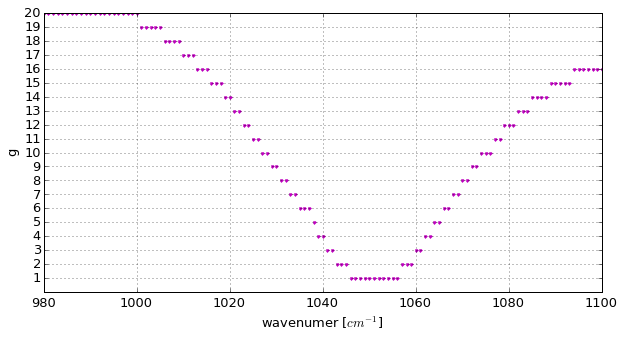

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(srs_mem.index, srs_mem.values, 
        color='m', linestyle='None', marker='.')

ax.grid(b=True)

ax.set_yticks(range(1, ng + 1))
ax.set_yticklabels(range(1, ng + 1))
ax.set_ylabel('g')

ax.set_xlabel('wavenumer [$cm^{-1}$]')

**Figure 3. G-group membership function.**  
The plot shows the g-group that a wavenumber belongs to.  

In [99]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
pd.cut?